# Quantum Chem. VQE-MUB Code, V2

Refactored to work with qiskit-nature 0.7.2 and qiskit 1.2.0.
Because everything else breaks all the way to hell.

Written by Ittay Alfassi, based on work from Dekel Meirom

### Required Versions:
- qiskit-nature==0.7.2  (via pip)
- pyscf==2.6.2          (via conda)
- matplotlib==3.9.2     (via conda)
- qiskit==1.2.0         (via pip, automatic when installing qiskit-nature)
- numpy==1.26.4         (built-in with conda)

### Required Infrastructure

- Linux or MacOS. **We highly recommend** to use the supplied dockerfile to set up a debian container.
- Miniconda3 (current version is conda 24.7.1)

## Imports

### General Imports

In [1]:
import qiskit
from qiskit import QuantumCircuit
import numpy as np
from numpy import sin,cos,pi,linspace,zeros
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.result import Counts, Result
from typing import Optional, List, Dict, Tuple, Union
from matplotlib import pyplot as plt
import itertools

### Quantum Chemistry Imports

In [2]:
from pyscf import scf
from pyscf import gto

In [3]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from qiskit_nature.second_q.problems.electronic_structure_problem import ElectronicStructureProblem
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

## Qubit operator generation functions

In [4]:
def get_qubit_op(molecule_str: str, charge: int = 0, basis: str = "sto3g", mapping_name: str = "parity", transformer: Optional[ActiveSpaceTransformer] = None) -> tuple[ElectronicStructureProblem, SparsePauliOp]:
    driver = PySCFDriver(
        atom=molecule_str,
        unit=DistanceUnit.ANGSTROM,
        charge=charge,
        basis=basis,
    )
    problem = driver.run()
    if transformer is not None:
        problem = transformer.transform(problem)
    second_q_op = problem.hamiltonian.second_q_op()
    if mapping_name == "parity":
        mapper = ParityMapper(num_particles=problem.num_particles)
    elif mapping_name == "jordan":
        mapper = JordanWignerMapper(num_particles=problem.num_particles)
    elif mapping_name == "bravi":
        mapper = BravyiKitaevMapper(num_particles=problem.num_particles)
    else:
        print("mapper should be one of parity, jordan or bravi")
        return None
    qubit_op = mapper.map(second_q_op)
    print('Number of particles', problem.num_particles)
    print('Number of spatial orbitals', problem.num_spatial_orbitals) 
    print('Number of qubits', qubit_op.num_qubits)
    print('Number of Paulis', qubit_op.size)
    return qubit_op, problem

In [5]:
def get_exact_energies(elec_struct_prob):
    numpy_solver = NumPyMinimumEigensolver()
    mapper=ParityMapper()
    calc = GroundStateEigensolver(mapper, numpy_solver)
    temp_res = calc.solve(elec_struct_prob)
    return temp_res, temp_res.total_energies[0], temp_res.nuclear_repulsion_energy

### Matrix Hamiltonians

In [6]:
def pauli_tensor_product(n, pauli_string):
    # Define Pauli matrices
    pauli_matrices = {
        'I': np.eye(2, dtype=complex),
        'X': np.array([[0, 1], [1, 0]], dtype=complex),
        'Y': np.array([[0, -1j], [1j, 0]], dtype=complex),
        'Z': np.array([[1, 0], [0, -1]], dtype=complex)
    }
    
    # Check if the input string length matches the number of qubits
    if len(pauli_string) != n:
        raise ValueError("Length of Pauli string must match the number of qubits (n).")
    
    # Start with the first matrix
    result = pauli_matrices[pauli_string[0]]
    
    # Perform the tensor product iteratively
    for char in pauli_string[1:]:
        result = np.kron(result, pauli_matrices[char])
    
    return result

def build_H_mat(H_op):
    n = len(H_op.paulis[0])
    num_strings = len(H_op.coeffs)
    H = np.zeros((2**n,2**n),dtype=np.complex128)
    for i in range(num_strings):
        coeff = H_op.coeffs[i]
        pauli = H_op.paulis[i]
        pauli_mat = pauli_tensor_product(n, pauli.to_label())
        H += coeff * pauli_mat 
    return H

def minimal_eigenvalue(matrix):
    # Compute eigenvalues using NumPy
    eigenvalues = np.linalg.eigvalsh(matrix)  # For Hermitian matrices (more efficient)
    return np.min(eigenvalues)

### Display Function for second-quanization Hamiltonian

## Several configutarions of LiH

The geometry, charge, set of basis elements, and mapping are the same. <br>
The active space transformers will differ. 

## !!! TO DO !!!
It seems that time to calculate with get_exact_energies (built-in qiskit method) is better than with minimal_eigenvalue (matrix-form function i wrote)

but the former is also doing the non normalized problem with 'expected norm 1 but instead got 1.00000000***...' for many terms in 2nd quantization Hamiltonian. Check this. 

Also - I drew the curve for LiH. It looks good with first method and not good for second method (see also attempt for H20 curve). (both below). What's wrong with diagonalization of a matrix? check this. p.s the first method worked becuase it is with 2 elecs and 2 spatial orbials - that is - not many orbitals. 

In [24]:
dist = "1.5"
atom_str = f"Li .0 .0 .0; H .0 .0 {dist}"
charge = 0
basis = 'sto3g'
mapping_name = "parity"

### (1) Default settings - 4 electrons and 6 spatial orbitals

In [25]:
transformer1 = None
LiH_qub_1, LiH_es_1 = get_qubit_op(atom_str, charge, basis, mapping_name, transformer1)
# print('GS energy:',get_exact_energies(LiH_es_1)[1])
print('GS energy:', minimal_eigenvalue(build_H_mat(LiH_qub_1)))
print(LiH_qub_1)
print(LiH_es_1.hamiltonian.second_q_op())

Number of particles (1, 1)
Number of spatial orbitals 2
Number of qubits 2
Number of Paulis 5
GS energy: -1.6303275411526188
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.06924349+0.j,  0.26752865+0.j, -0.26752865+0.j, -0.00901493+0.j,
  0.19679058+0.j])
Fermionic Operator
number spin orbitals=4, number terms=36
  -1.1108441798837274 * ( +_0 -_0 )
+ -0.5891210037060841 * ( +_1 -_1 )
+ -1.1108441798837274 * ( +_2 -_2 )
+ -0.5891210037060841 * ( +_3 -_3 )
+ 0.31320124976475905 * ( +_0 +_0 -_0 -_0 )
+ 0.3108533815598568 * ( +_0 +_1 -_1 -_0 )
+ 0.31320124976475905 * ( +_0 +_2 -_2 -_0 )
+ 0.3108533815598568 * ( +_0 +_3 -_3 -_0 )
+ 0.09839529174273512 * ( +_0 +_0 -_1 -_1 )
+ 0.09839529174273512 * ( +_0 +_1 -_0 -_1 )
+ 0.09839529174273512 * ( +_0 +_2 -_3 -_1 )
+ 0.09839529174273512 * ( +_0 +_3 -_2 -_1 )
+ 0.09839529174273512 * ( +_1 +_0 -_1 -_0 )
+ 0.09839529174273512 * ( +_1 +_1 -_0 -_0 )
+ 0.09839529174273512 * ( +_1 +_2 -_3 -_0 )
+ 0.09839529174273512 * ( +_1 +_3 -

### (2) Active space: 2 electrons, 2 spatial orbitals

In [23]:
transformer2 = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=2)
LiH_qub_2, LiH_es_2 = get_qubit_op(atom_str, charge, basis, mapping_name, transformer2)
print('GS energy:', minimal_eigenvalue(build_H_mat(LiH_qub_2)))
# print('GS energy:',get_exact_energies(LiH_es_2)[1])
print(LiH_qub_2)
print(LiH_es_2.hamiltonian.second_q_op())

Number of particles (1, 1)
Number of spatial orbitals 2
Number of qubits 2
Number of Paulis 9
GS energy: -1.1577119298130487
SparsePauliOp(['II', 'IZ', 'IX', 'ZI', 'XI', 'ZZ', 'XZ', 'ZX', 'XX'],
              coeffs=[-0.90875945+0.j,  0.17065563+0.j,  0.01871115+0.j, -0.17065563+0.j,
  0.01871115+0.j, -0.09249335+0.j,  0.01871119+0.j, -0.01871119+0.j,
  0.00946591+0.j])
Fermionic Operator
number spin orbitals=4, number terms=72
  -0.8409202628899362 * ( +_0 -_0 )
+ 0.0388117553138337 * ( +_0 -_1 )
+ 0.038811755313833726 * ( +_1 -_0 )
+ -0.40697942160565637 * ( +_1 -_1 )
+ -0.8409202628899362 * ( +_2 -_2 )
+ 0.0388117553138337 * ( +_2 -_3 )
+ 0.038811755313833726 * ( +_3 -_2 )
+ -0.40697942160565637 * ( +_3 -_3 )
+ 0.2621315805844258 * ( +_0 +_0 -_0 -_0 )
+ -0.019405897635722508 * ( +_0 +_0 -_1 -_0 )
+ -0.019405897635722508 * ( +_0 +_1 -_0 -_0 )
+ 0.12332344003130778 * ( +_0 +_1 -_1 -_0 )
+ 0.2621315805844258 * ( +_0 +_2 -_2 -_0 )
+ -0.019405897635722508 * ( +_0 +_2 -_3 -_0 )
+ -0.01940

### (3) LiH with active orbitals 1,2 (out of 0,1,2,3)

In [10]:
transformer3 = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=2, active_orbitals=[1,2])
LiH_qub_3, LiH_es_3 = get_qubit_op(atom_str, charge, basis, mapping_name, transformer3)
print('GS energy:',get_exact_energies(LiH_es_3)[1])
print(LiH_qub_3)
print(LiH_es_3.hamiltonian.second_q_op())

Number of particles (1, 1)
Number of spatial orbitals 2
Number of qubits 2
Number of Paulis 9
GS energy: -7.863579821677107
SparsePauliOp(['II', 'IZ', 'IX', 'ZI', 'XI', 'ZZ', 'XZ', 'ZX', 'XX'],
              coeffs=[-0.8283753 +0.j,  0.17399667+0.j,  0.02654859+0.j, -0.17399667+0.j,
  0.02654859+0.j, -0.09496265+0.j,  0.02654859+0.j, -0.02654859+0.j,
  0.01213863+0.j])
Fermionic Operator
number spin orbitals=4, number terms=72
  -0.787844741287687 * ( +_0 -_0 )
+ 0.04693450040879917 * ( +_0 -_1 )
+ 0.04693450040879903 * ( +_1 -_0 )
+ -0.362117485276752 * ( +_1 -_1 )
+ -0.787844741287687 * ( +_2 -_2 )
+ 0.04693450040879917 * ( +_2 -_3 )
+ 0.04693450040879903 * ( +_3 -_2 )
+ -0.362117485276752 * ( +_3 -_3 )
+ 0.24714174399725858 * ( +_0 +_0 -_0 -_0 )
+ -0.023467248713463243 * ( +_0 +_0 -_1 -_0 )
+ -0.023467248713463243 * ( +_0 +_1 -_0 -_0 )
+ 0.11331213551045904 * ( +_0 +_1 -_1 -_0 )
+ 0.24714174399725858 * ( +_0 +_2 -_2 -_0 )
+ -0.023467248713463243 * ( +_0 +_2 -_3 -_0 )
+ -0.0234672487

### (4) Active space: 2 electrons, 2 spatial orbitals

In [11]:
transformer4 = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=3)
LiH_qub_4, LiH_es_4 = get_qubit_op(atom_str, charge, basis, mapping_name, transformer4)
print('GS energy:',get_exact_energies(LiH_es_4)[1])
print(LiH_qub_4)
print(LiH_es_4.hamiltonian.second_q_op())

Number of particles (1, 1)
Number of spatial orbitals 3
Number of qubits 4
Number of Paulis 52


QiskitError: 'Sum of amplitudes-squared is not 1, but 0.9999999753981055.'

### (5) LiH with active orbitals 1,2,5 (out of 0,1,2,3,4,5)

In [ ]:
transformer5 = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=3, active_orbitals=[1,2,5])
LiH_qub_5, LiH_es_5 = get_qubit_op(atom_str, charge, basis, mapping_name, transformer5)
print('GS energy:',get_exact_energies(LiH_es_5)[1])
print(LiH_qub_5)
print(LiH_es_5.hamiltonian.second_q_op())

## LiH GS energy as function of distance

Number of particles (1, 1)
Number of spatial orbitals 2
Number of qubits 2
Number of Paulis 9
Number of particles (1, 1)
Number of spatial orbitals 2
Number of qubits 2
Number of Paulis 9
Number of particles (1, 1)
Number of spatial orbitals 2
Number of qubits 2
Number of Paulis 9
Number of particles (1, 1)
Number of spatial orbitals 2
Number of qubits 2
Number of Paulis 9
Number of particles (1, 1)
Number of spatial orbitals 2
Number of qubits 2
Number of Paulis 9
Number of particles (1, 1)
Number of spatial orbitals 2
Number of qubits 2
Number of Paulis 9
Number of particles (1, 1)
Number of spatial orbitals 2
Number of qubits 2
Number of Paulis 9
Number of particles (1, 1)
Number of spatial orbitals 2
Number of qubits 2
Number of Paulis 9
Number of particles (1, 1)
Number of spatial orbitals 2
Number of qubits 2
Number of Paulis 9
Number of particles (1, 1)
Number of spatial orbitals 2
Number of qubits 2
Number of Paulis 9


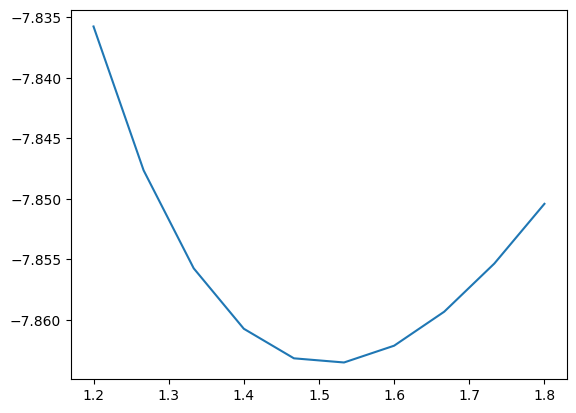

In [27]:
known_R = 1.5
Rs = linspace(0.8*known_R, 1.2*known_R, 10)
transormer_LiH = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=2)
energies = np.zeros(len(Rs))
for i, R in enumerate(Rs):
    atom_str = f"Li .0 .0 .0; H .0 .0 {R}"
    qubit_op, es = get_qubit_op(atom_str, charge, basis, mapping_name, transormer_LiH)
    energies[i] = get_exact_energies(es)[1]
    # CHECK WHY THE METHOD BELOW GIVES SOMETHING DIFFERNET!!!
    # energies[i] = minimal_eigenvalue(build_H_mat(qubit_op))

plt.plot(Rs, energies)

## H2O GS energy as function of distance and angle

In [50]:

atom_str = (
    f"O .0 .0 .0; "
    f"H {R * cos(theta / 2):.3f} {R * sin(theta / 2):.3f} .0; "
    f"H {R * cos(theta / 2):.3f} {-R * sin(theta / 2):.3f} .0"
)
charge = 0
basis = 'sto3g'
mapping_name = "parity"

transformer_H2O = ActiveSpaceTransformer(num_electrons=4, num_spatial_orbitals=4)
H2O_qub, H2O_es = get_qubit_op(atom_str, charge, basis, mapping_name, transformer_H2O)
# print('GS energy:',get_exact_energies(H2O_es)[1])
print('GS energy:', minimal_eigenvalue(build_H_mat(H2O_qub)))
print(H2O_qub)
print(H2O_es.hamiltonian.second_q_op())

Number of particles (2, 2)
Number of spatial orbitals 4
Number of qubits 6
Number of Paulis 95
GS energy: -6.353216332178398
SparsePauliOp(['IIIIII', 'IIIIIZ', 'IIIZXX', 'IIIIYY', 'IIIIZZ', 'IIIZZI', 'IIIZII', 'IIZIII', 'ZXXIII', 'IYYIII', 'IZZIII', 'ZZIIII', 'ZIIIII', 'IIIIZI', 'IIIZZZ', 'IIIZIZ', 'IIZIIZ', 'ZXXIIZ', 'IYYIIZ', 'IZZIIZ', 'ZZIIIZ', 'ZIIIIZ', 'IIIZYY', 'IIIIXX', 'IZXIZX', 'IIXIZX', 'IZXIIX', 'IIXIIX', 'ZXZIZX', 'IXIIZX', 'ZXZIIX', 'IXIIIX', 'IIZZXX', 'IIZIYY', 'ZXXZXX', 'IYYZXX', 'ZXXIYY', 'IYYIYY', 'IZZZXX', 'IZZIYY', 'ZZIZXX', 'ZZIIYY', 'ZIIZXX', 'ZIIIYY', 'XXXXXX', 'YXYXXX', 'XXXYXY', 'YXYYXY', 'XZIXXX', 'XIIXXX', 'XZIYXY', 'XIIYXY', 'IIZIZZ', 'ZXXIZZ', 'IYYIZZ', 'IZZIZZ', 'ZZIIZZ', 'ZIIIZZ', 'IZXZXZ', 'IIXZXZ', 'IZXIXI', 'IIXIXI', 'ZXZZXZ', 'IXIZXZ', 'ZXZIXI', 'IXIIXI', 'XXZXXZ', 'YYIXXZ', 'XXZYYI', 'YYIYYI', 'IIZZZI', 'ZXXZZI', 'IYYZZI', 'IZZZZI', 'ZZIZZI', 'ZIIZZI', 'XXXXZI', 'YXYXZI', 'XXXXII', 'YXYXII', 'XZIXZI', 'XIIXZI', 'XZIXII', 'XIIXII', 'IIZZII', 'ZXXZII', 

In [8]:
# Constants and initialization
known_R = 0.9584
known_theta = 104.5 * pi / 180  # Convert to radians
Rs = linspace(0.9, 1.1, 5) * known_R  # Generate scaled bond lengths
thetas = linspace(0.9, 1.1, 5) * known_theta  # Generate scaled bond angles
energies = np.zeros((len(Rs), len(thetas)))  # Initialize energy grid

atom_str = (
    f"O .0 .0 .0; "
    f"H {known_R * cos(known_theta / 2):.3f} {known_R * sin(known_theta / 2):.3f} .0; "
    f"H {known_R * cos(known_theta / 2):.3f} {-known_R * sin(known_theta / 2):.3f} .0"
)

# Calculate energies
for i, R in enumerate(Rs):
    for j, theta in enumerate(thetas):
        atom_str = (
            f"O .0 .0 .0; "
            f"H {R * cos(theta / 2):.3f} {R * sin(theta / 2):.3f} .0; "
            f"H {R * cos(theta / 2):.3f} {-R * sin(theta / 2):.3f} .0"
        )
        H2O_qub, H2O_es = get_qubit_op(atom_str, charge, basis, mapping_name, transformer_H2O)
        H2O_qub_mat = build_H_mat(H2O_qub)
        energies[i, j] = minimal_eigenvalue(H2O_qub_mat)
        print('GS energy=',energies[i, j],'R=',R,'theta=',theta)

# Create meshgrid and contour plot
X, Y = np.meshgrid(Rs, thetas)  # Create 2D grid for Rs and thetas
plt.figure(figsize=(len(Rs), len(thetas)))
contour = plt.contourf(X, Y, energies.T, cmap='viridis')  # Transpose energies for correct orientation
plt.colorbar(contour, label='Energy (a.u.)')
plt.xlabel('Bond Length (R)')
plt.ylabel('Bond Angle (Theta)')
plt.title('Contour Plot of H2O Energy')
plt.show()

NameError: name 'get_qubit_op' is not defined